# **Final Project- Emotions audio detection**

In [1]:
'''
Final project
Ido Shirat
201116175
classification of audio emotions files
https://www.kaggle.com/uldisvalainis/audio-emotions
'''

'\nFinal project\nIdo Shirat\n201116175\nclassification of audio emotions files\nhttps://www.kaggle.com/uldisvalainis/audio-emotions\n'

# Goal

My goal is to get 80% accuracy

# Install packges

In [2]:
!pip install pydub
!pip install playsound
!pip install librosa
!pip install keras
!sudo apt-get install libportaudio2
!pip install sounddevice
!pip install pygobject
!pip install audiomentations 
!pip install pygobject
!pip install ffmpeg-python


  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7037 sha256=9018b42cdee45e81f7db5754e17ff4eb8d007113505d6b25feaa12abd2954ab7
  Stored in directory: /root/.cache/pip/wheels/ba/f8/bb/ea57c0146b664dca3a0ada4199b0ecb5f9dfcb7b7e22b65ba2
Successfully built playsound
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 1s (108 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Read

# Import packges

In [3]:
## Import packges
# General Tools
import json
import numpy as np
import scipy as sp
import pandas as pd
import glob
from pathlib import Path
import math

# SK Learn
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Keras
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Model, Input
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, MaxPool1D, Flatten, Conv2D, MaxPooling2D,BatchNormalization ,UpSampling2D, LSTM, RepeatVector, TimeDistributed, Embedding, Conv1D, MaxPooling1D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam, Adadelta, SGD
from tensorflow.keras.datasets import mnist
from keras.utils import np_utils
# import keras

# Misc
import random
from random import sample
import warnings
from sys import modules
from time import time
import os
from platform import python_version

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# IPython
from IPython.display import Image, display

# Audio
from playsound import playsound
from scipy.io import wavfile
from pydub import AudioSegment
from pydub.playback import play
from IPython.display import Audio
import sounddevice as sd
import librosa
import librosa.display
import time
import glob
import ffmpeg
import soundfile as sf
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Confuguration
warnings.filterwarnings('ignore')


playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


# Examine if GPU is available

In [4]:
#<! Check if GPU is available
#<! See also https://www.tensorflow.org/guide/gpu
#
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


# Mount Drive

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Data inspection

In [19]:
# Audio exmaples from each category

Angry_exp = '/content/gdrive/My Drive/Final_project_Naya/Emotions/Angry/03-01-05-01-01-01-01.wav'
Disgusted_exp = '/content/gdrive/My Drive/Final_project_Naya/Emotions/Disgusted/03-01-07-01-01-01-01.wav'
Fearful_exp = '/content/gdrive/My Drive/Final_project_Naya/Emotions/Fearful/03-01-06-01-01-01-01.wav'
Happy_exp = '/content/gdrive/My Drive/Final_project_Naya/Emotions/Happy/03-01-03-01-01-01-01.wav'
Neutral_exp = '/content/gdrive/My Drive/Final_project_Naya/Emotions/Neutral/03-01-01-01-01-01-02.wav'
Sad_exp = '/content/gdrive/My Drive/Final_project_Naya/Emotions/Sad/03-01-04-01-01-01-01.wav'
Suprised_exp = '/content/gdrive/My Drive/Final_project_Naya/Emotions/Suprised/03-01-08-01-01-01-01.wav'

Emotions_exp_list = [Angry_exp,Disgusted_exp,Fearful_exp,Happy_exp,Neutral_exp,Sad_exp,Suprised_exp]


SHOW_AUDIO_EXAMPELS = False

# play examples audio
if SHOW_AUDIO_EXAMPELS:
  for exp in Emotions_exp_list:
    audio_exp = Audio(exp)
    emotion_type = exp.split('/')[-2]
    print('\n')
    print('{:^35s}'.format(emotion_type))
    display(audio_exp)
    print('\n')

Output hidden; open in https://colab.research.google.com to view.

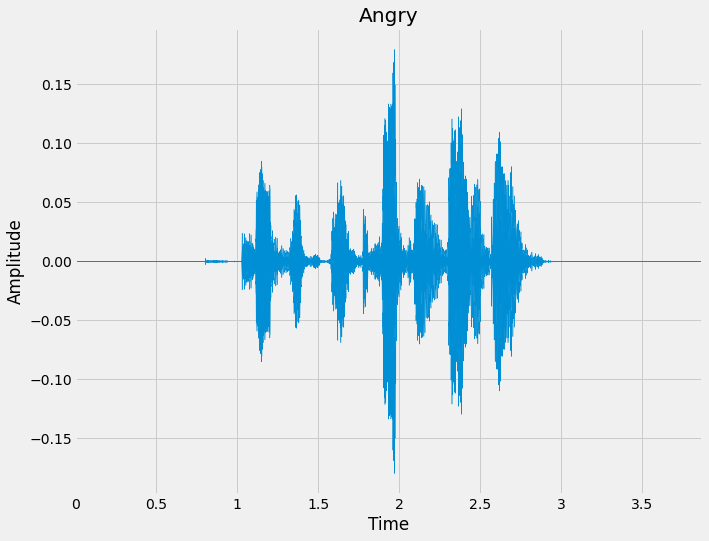

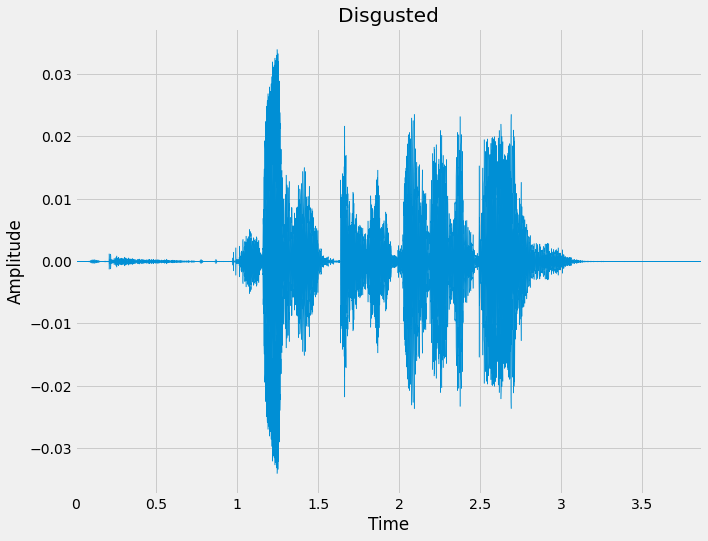

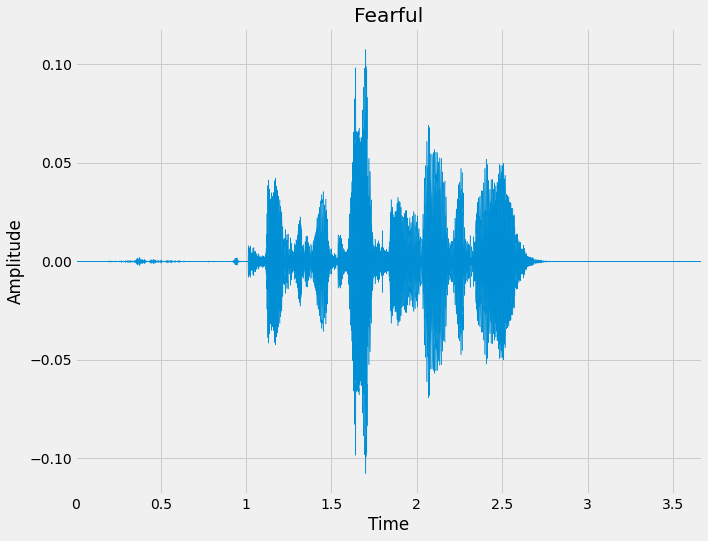

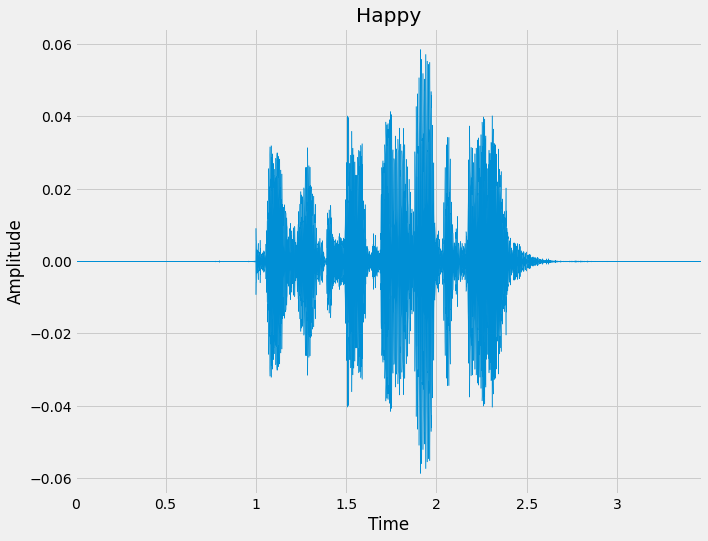

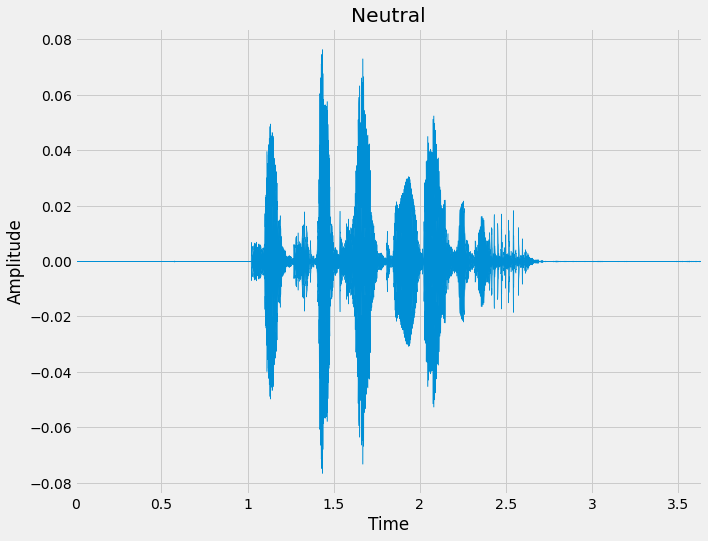

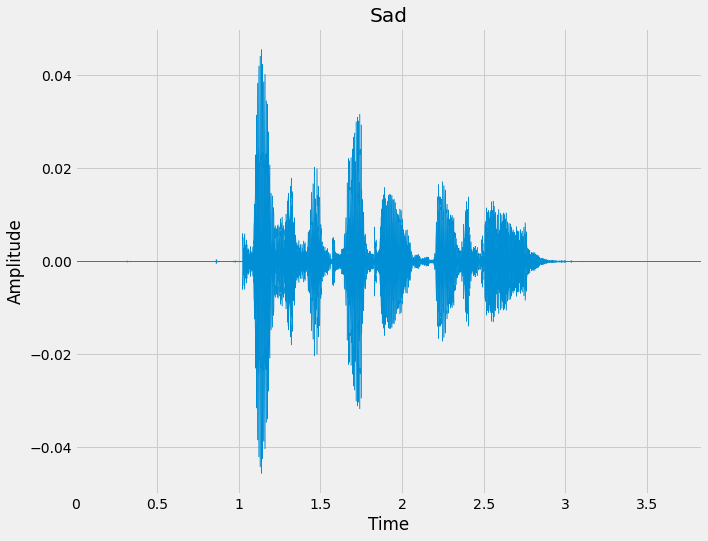

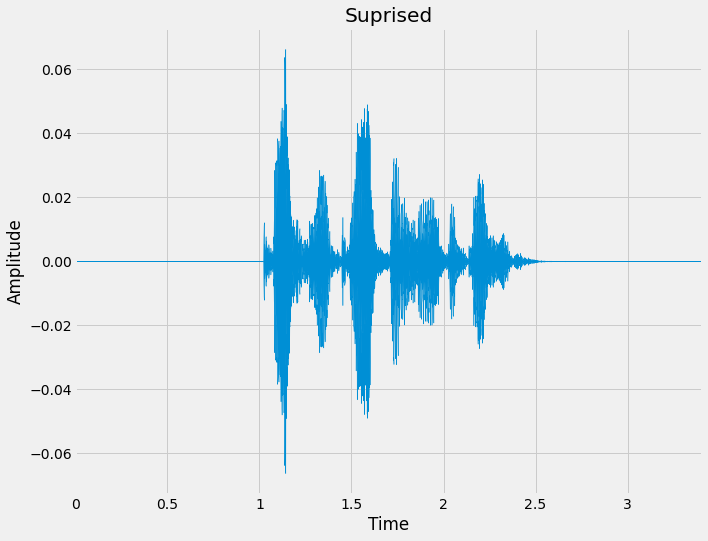

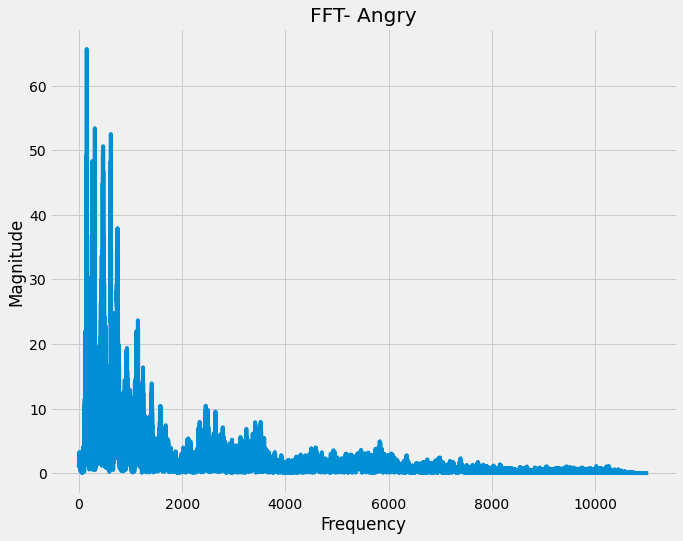

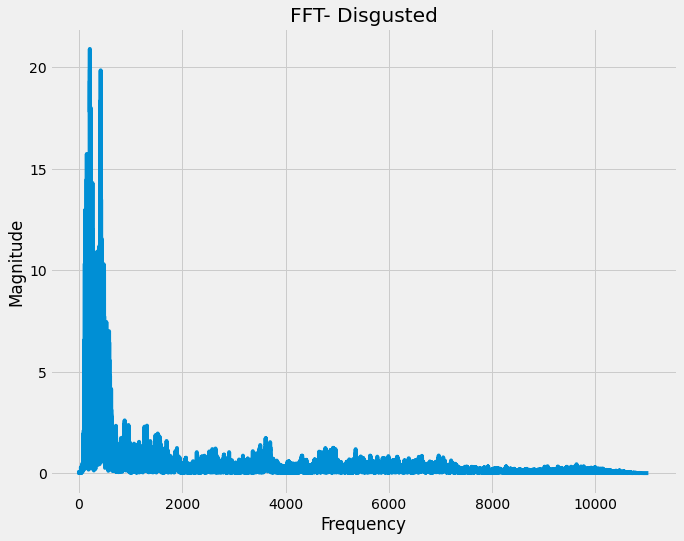

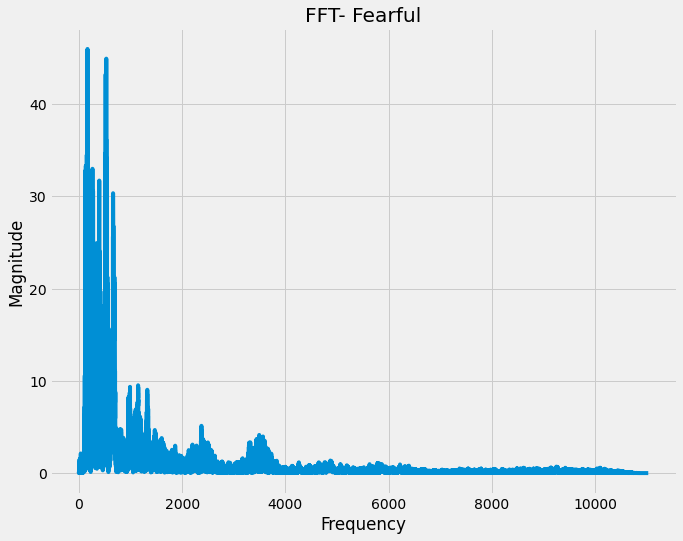

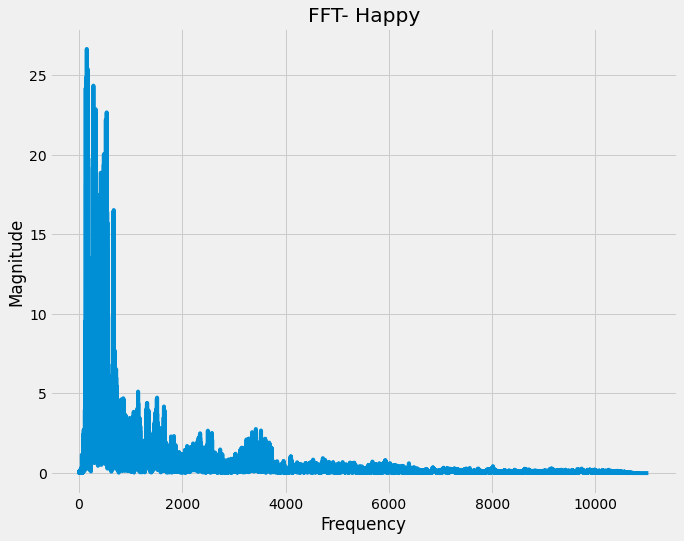

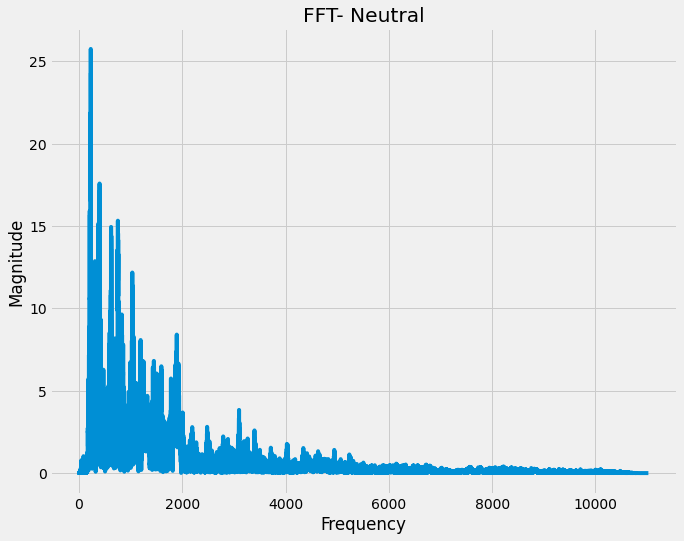

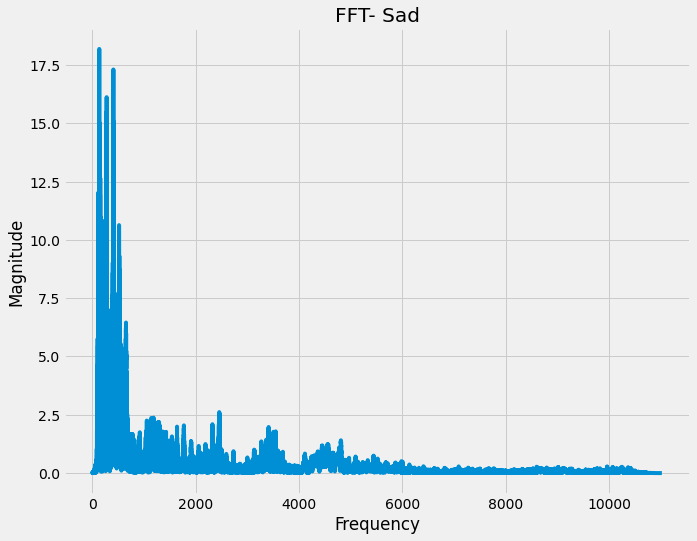

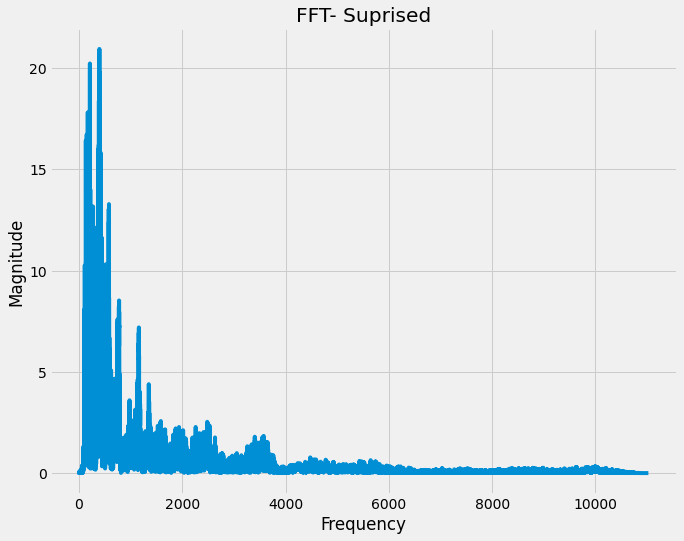

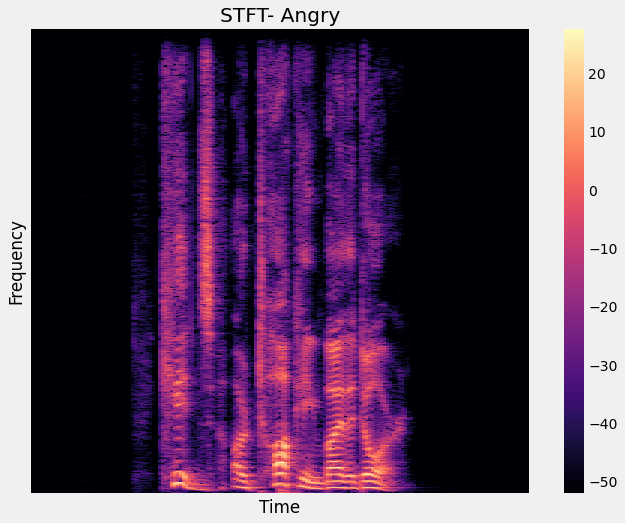

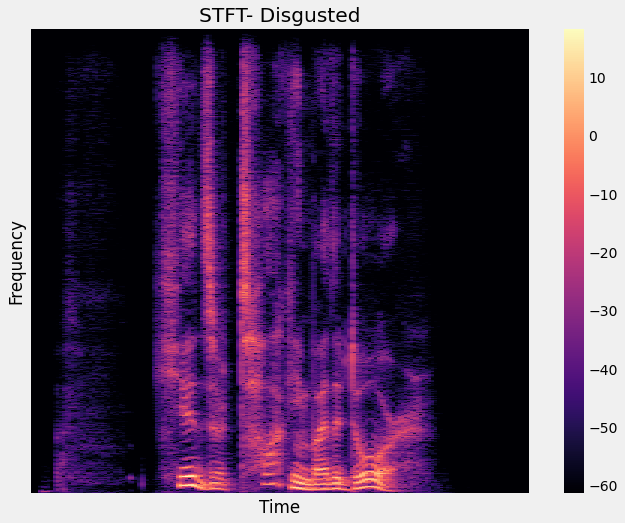

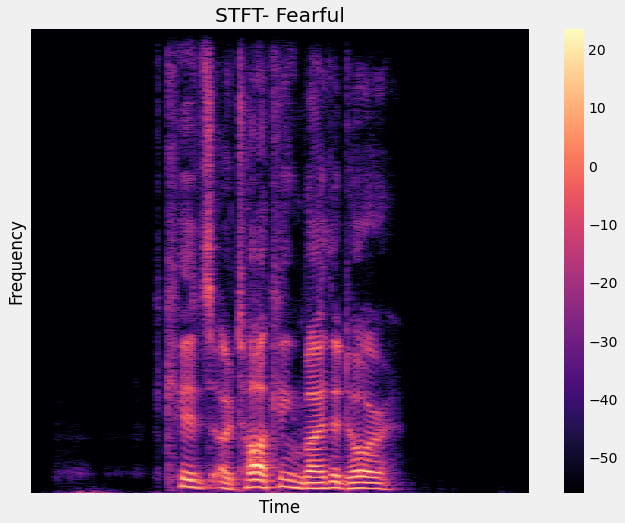

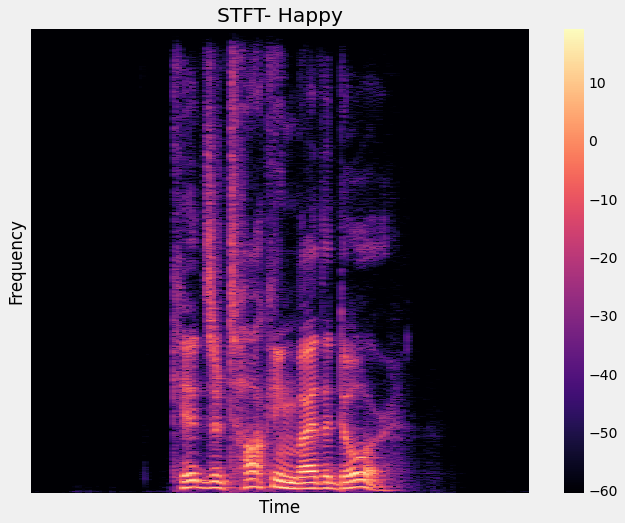

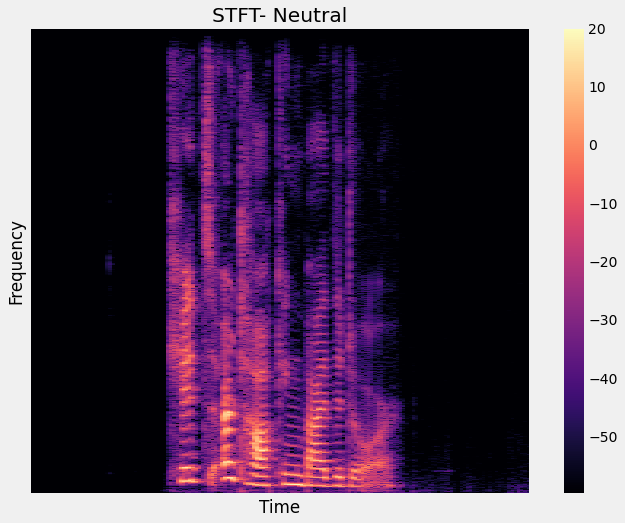

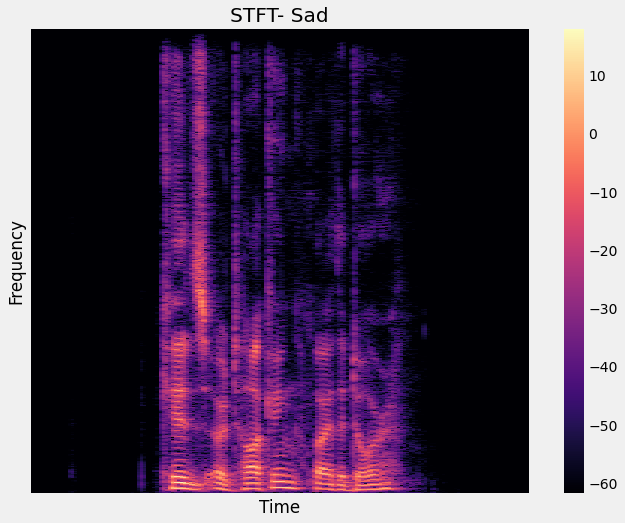

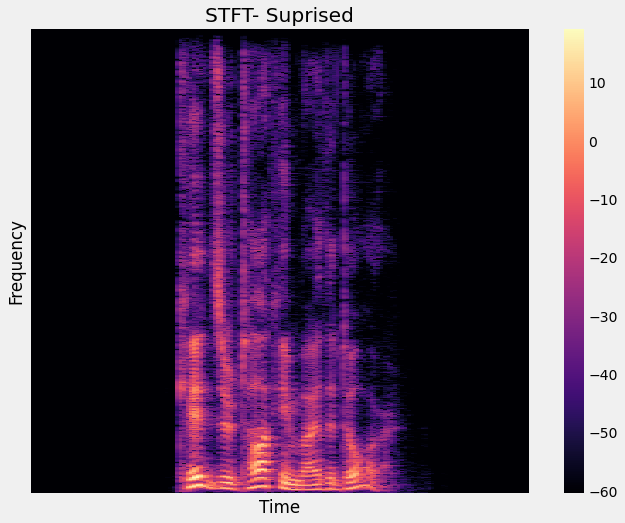

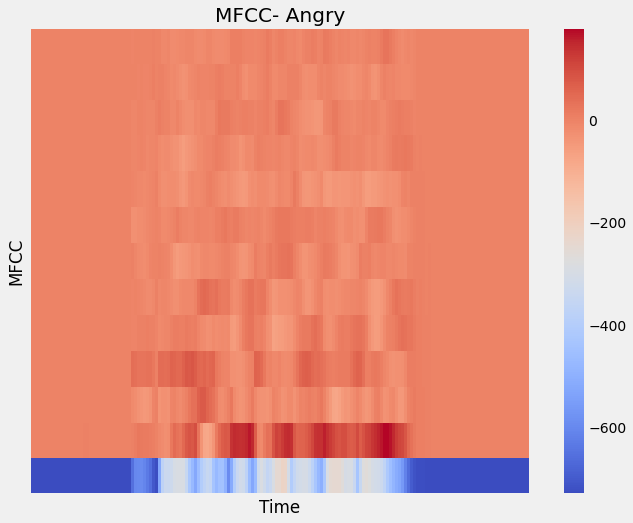

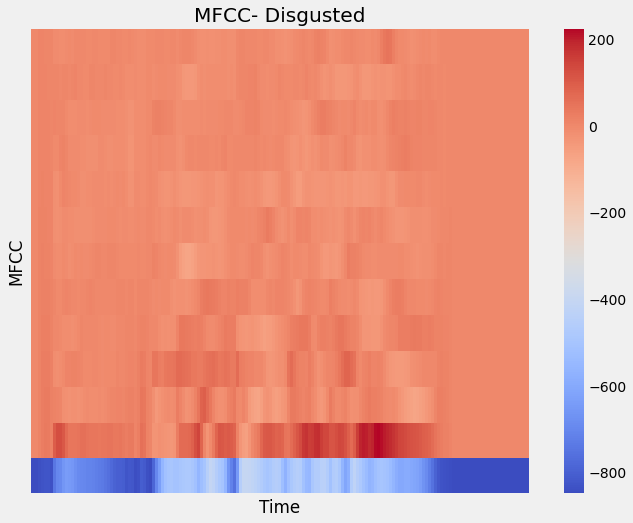

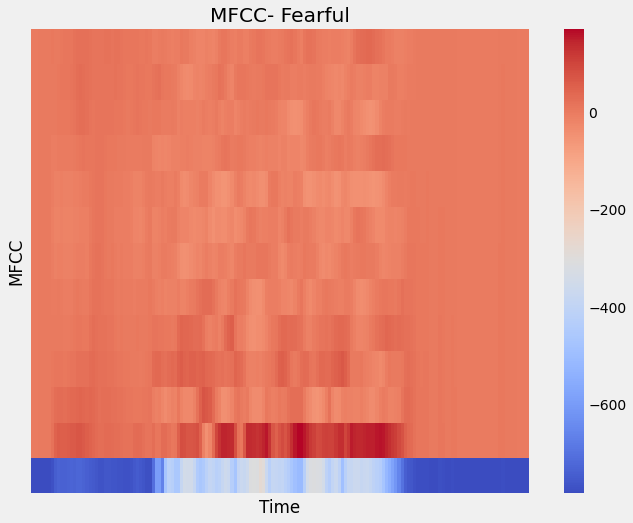

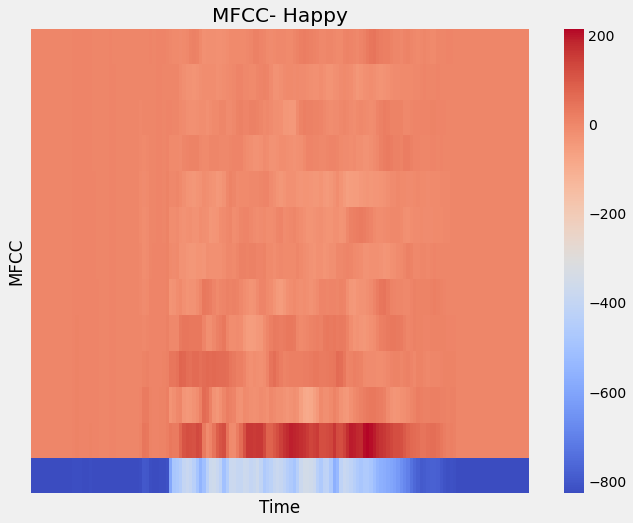

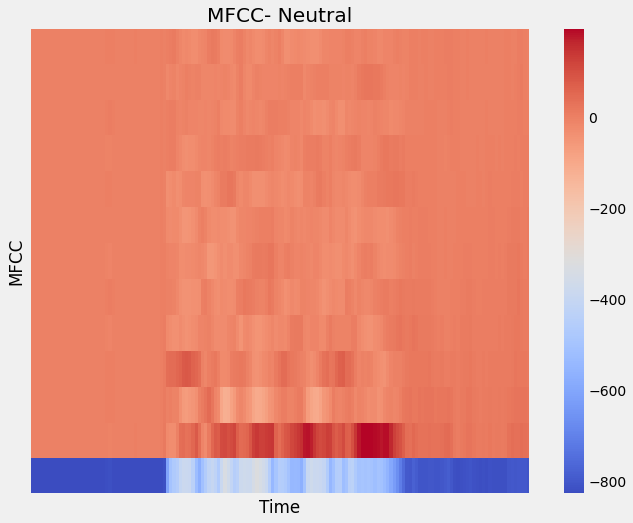

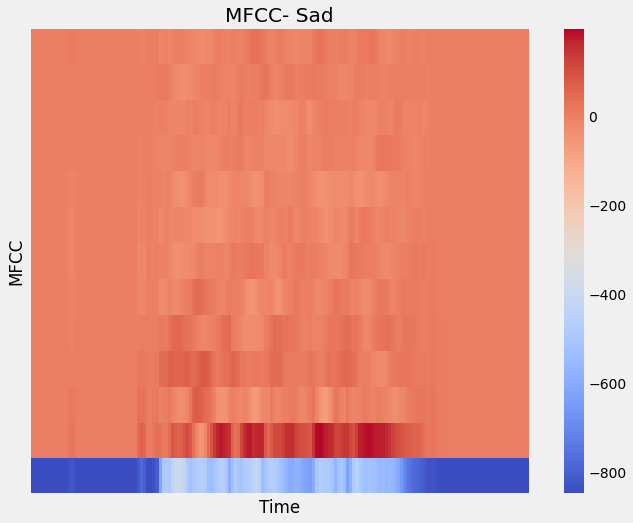

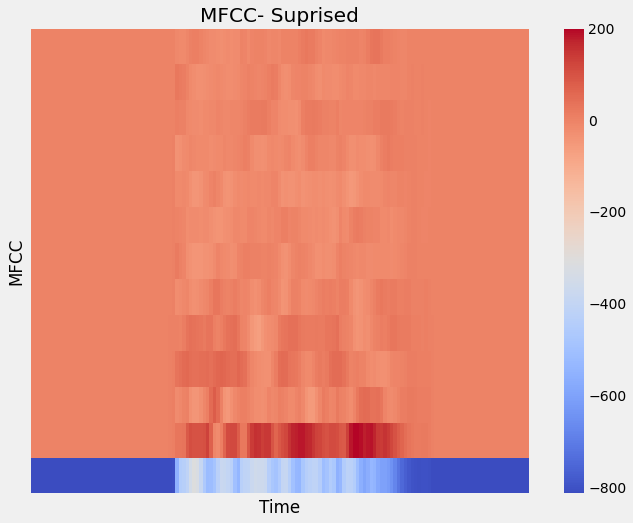

In [20]:
## example of audio
def simple_audio_plot(exp, emotion_type):
  singal, sr = librosa.load(exp, sr=22050) 
  plt.style.use('fivethirtyeight')
  plt.figure(figsize= (10,8))
  librosa.display.waveplot(singal,sr=sr)
  plt.xlabel('Time')
  plt.ylabel('Amplitude')
  plt.title(emotion_type)
  plt.show()

## Transform audio using fourier trasnfromation and plot it (Frequency X Magnitude)
def FFT_plot(exp, emotion_type, sample_rate):
  singal, sr = librosa.load(exp, sr=sample_rate) 
  fft = np.fft.fft(singal)
  magnitude = np.abs(fft)
  frequency = np.linspace(0,sr,len(magnitude))
  left_frequency = frequency[:int(len(frequency)/2)]
  left_magnitude = magnitude[:int(len(magnitude)/2)]
  plt.style.use('fivethirtyeight')
  plt.figure(figsize= (10,8))
  plt.plot(left_frequency,left_magnitude)
  plt.xlabel('Frequency')
  plt.ylabel('Magnitude')
  plt.title(f'FFT- {emotion_type}')
  plt.show()

## Transform audio using fourier trasnfromation to a short time fourier trasnfromation matrix (Time X Frequency X Decibel)
def STFT_plot(exp, emotion_type,sample_rate, n_fft, hop_length):
  singal, sr = librosa.load(exp, sr=sample_rate) 
  stft = librosa.core.stft(singal, hop_length= hop_length, n_fft= n_fft)
  spectrogram = np.abs(stft)
  log_spectrogram = librosa.amplitude_to_db(spectrogram)

  plt.figure(figsize= (10,8))
  librosa.display.specshow(log_spectrogram, sr= sr, hop_length= hop_length)
  plt.xlabel('Time')
  plt.ylabel('Frequency')
  plt.title(f'STFT- {emotion_type}')
  plt.colorbar()
  plt.show()

## Transform audio MFFCs matrix (Time X MFCC X Magnitude)
def MFCC_plot(exp, emotion_type,sample_rate, n_fft, hop_length, n_mfcc):
  singal, sr = librosa.load(exp, sr=sample_rate) 
  MFCC = librosa.feature.mfcc(singal, n_fft= n_fft, hop_length= hop_length, n_mfcc= n_mfcc)
  plt.figure(figsize= (10,8))
  librosa.display.specshow(MFCC, sr= sr, hop_length= hop_length)
  plt.xlabel('Time')
  plt.ylabel('MFCC')
  plt.title(f'MFCC- {emotion_type}')
  plt.colorbar()
  plt.show()

if SHOW_AUDIO_EXAMPELS:
  sample_rate = 22050
  n_fft = 2048 
  hop_length = 512 
  n_mfcc = 13

  for exp in Emotions_exp_list:
    emotion_type = exp.split('/')[-2]
    simple_audio_plot(exp, emotion_type)
    
  print('\n')
  for exp in Emotions_exp_list:
    emotion_type = exp.split('/')[-2]
    FFT_plot(exp, emotion_type, sample_rate)

  print('\n')
  for exp in Emotions_exp_list:
    emotion_type = exp.split('/')[-2]
    STFT_plot(exp, emotion_type,sample_rate, n_fft, hop_length)

  print('\n')
  for exp in Emotions_exp_list:
    emotion_type = exp.split('/')[-2]
    MFCC_plot(exp, emotion_type,sample_rate, n_fft, hop_length, n_mfcc)

# Non- generator based

## Save and load data functions

In [7]:
def save_mfccs(audio_path,json_save_path,SR,n_fft, hop_length,n_mfcc, resample_type, to_augment = False):

  if to_augment:
    noise = Compose([AddGaussianNoise(min_amplitude=0.0001, max_amplitude=0.001, p=0.65)])
    time_strech = Compose([TimeStretch(min_rate=0.6, max_rate=1.25, p=0.6), ])
    pitch_shift = Compose([PitchShift(min_semitones=-4, max_semitones=4, p=0.7)])
    shift = Compose([Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5)])

    augmnet_list = [noise,time_strech,pitch_shift,shift]


  i = -2
  lst = []
  dict_data = {'mfcc':[], 'labels':[],'mapping':[]}
  start_time = time.time()
  for subdir, dirs, files in os.walk(audio_path):
      i=i+1
      print(subdir)
      print(i)
      path_components = subdir.split("\\")
      label = path_components[-1]
      for file in files:
        
          # Load librosa array, obtain mfcss, add them to dict.
          signal, sample_rate = librosa.load(os.path.join(subdir,file),sr = SR, res_type=resample_type)
          mfccs = librosa.feature.mfcc(signal, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc).T
          dict_data['mfcc'].append(mfccs.tolist())
          dict_data['labels'].append(i-1)
          dict_data['mapping'].append(label)

          if to_augment:
            augment = augmnet_list[np.random.choice(4,1)[0]]
            augmented_file = augment(samples=signal, sample_rate=sample_rate)
            mfccs = librosa.feature.mfcc(augmented_file, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc).T
            dict_data['mfcc'].append(mfccs.tolist())
            dict_data['labels'].append(i - 1)
            dict_data['mapping'].append(label)

  with open(json_save_path,"w") as fp:
      json.dump(dict_data, fp, indent=4)

def save_mel_spec(audio_path,json_save_path,SR,n_fft, hop_length,n_mels, resample_type, augment = False):
  if augment:
    noise = Compose([AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5)])
    # time_strech = Compose([TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5), ])
    # pitch_shift = Compose([PitchShift(min_semitones=-4, max_semitones=4, p=0.7)])
    # shift = Compose([Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5)])

    # augmnet_list = [noise,time_strech]
    augmnet_list = [noise]
  i = -2
  lst = []
  dict_data = {'mels':[], 'labels':[],'mapping':[]}
  start_time = time.time()
  for subdir, dirs, files in os.walk(audio_path):
      i=i+1
      print(subdir)
      print(i)
      path_components = subdir.split("\\")
      label = path_components[-1]
      for file in files:
        
          #Load librosa array, obtain mfcss, add them to array and then to list.
          signal, sample_rate = librosa.load(os.path.join(subdir,file),sr = SR, res_type=resample_type)
          S = librosa.feature.melspectrogram(signal, sr=sample_rate, n_mels=n_mels, fmax=8000).T
          mels = librosa.power_to_db(S,ref = np.max)

          dict_data['mels'].append(mels.tolist())
          dict_data['labels'].append(i-1)
          dict_data['mapping'].append(label)

          if augment:
            for augment in augmnet_list:
              augmented_file = augment(samples=signal, sample_rate=sample_rate)
              S = librosa.feature.melspectrogram(augmented_file, sr=sample_rate, n_mels=n_mels, fmax=8000).T
              mels = librosa.power_to_db(S,ref = np.max)
              dict_data['mels'].append(mels.tolist())
              dict_data['labels'].append(i - 1)
              dict_data['mapping'].append(label)

  with open(json_save_path,"w") as fp:
      json.dump(dict_data, fp, indent=4)



def load_json(json_path, padding_val = 500,n_MFCC = 40, size= 12798):
    with open(json_path, "r") as fp:
        data = json.load(fp)
        X = np.array(data['mfcc'])
        y = np.array(data['labels'])
        X_extra = np.empty ((size,padding_val,n_MFCC))
        for i in range(len(X)):
            extra =padding_val-np.array(X[i]).shape[0]
            X_extra[i,:,:] = np.pad(np.array(X[i]),pad_width=((extra,0),(0,0)), mode='constant', constant_values=0)
        return X_extra, y


def save_files_list(audio_path, files_list_path):
  files_list = []
  for subdir, dirs, files in os.walk(audio_path):
      for file in files:
        file_path = subdir + '\\'+ file
        files_list.append(file_path)
  files_list_df = pd.Series(files_list) 
  files_list_df.to_csv(files_list_path)


## Data Augmentation

In [9]:

if SHOW_AUDIO_EXAMPELS:
  sample_rate = 22050
  Angry_exp = '/content/gdrive/My Drive/Final_project_Naya/Emotions/Angry/03-01-05-01-01-01-01.wav'

  noise = Compose([AddGaussianNoise(min_amplitude=0.0001, max_amplitude=0.001, p=0.65)])
  time_strech = Compose([TimeStretch(min_rate=0.6, max_rate=1.25, p=0.1), ])
  pitch_shift = Compose([PitchShift(min_semitones=-4, max_semitones=4, p=0.6)])
  shift = Compose([Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5)])


  signal, sample_rate = librosa.load(Angry_exp,sr = sample_rate)

  print('True file')
  exp = Audio(Angry_exp)
  display(exp)

  print('\naugemnted noise file')
  augmented_file = noise(samples=signal, sample_rate=sample_rate)
  noise_aug = Audio(augmented_file, rate= 22050)
  display(noise_aug)

  print('\naugemnted time_strech file')
  augmented_file = time_strech(samples=signal, sample_rate=sample_rate)
  ts_aug = Audio(augmented_file, rate= 22050)
  display(ts_aug)

  print('\naugemnted pitch_shift file')
  augmented_file = pitch_shift(samples=signal, sample_rate=sample_rate)
  ps_aug = Audio(augmented_file, rate= 22050)
  display(ps_aug)


  print('\naugemnted shift file')
  augmented_file = shift(samples=signal, sample_rate=sample_rate)
  s_aug = Audio(augmented_file, rate= 22050)
  display(s_aug)


## Save proccesed data

In [11]:
# Paths
audio_path = '/content/gdrive/My Drive/Final_project_Naya/Emotions'
json_mfccs_path = '/content/gdrive/My Drive/Final_project_Naya/data_mfccs_augment.json'
json_mel_path = '/content/gdrive/My Drive/Final_project_Naya/data_mel_spec_augment.json'
files_list_path = '/content/gdrive/My Drive/Final_project_Naya/files_list.csv'

# HP
resample_type = 'kaiser_fast' # kaiser_best, kaiser_fast
SR = 22050
n_fft = 2048
hop_length = 512
n_mfcc = 40
n_mels = 40
to_augment = True

# Create files
SAVE_MFCCS = False
SAVE_MEL_SPECS = False
SAVE_FILE_LIST = False

if SAVE_MFCCS:
  save_mfccs(audio_path,json_mfccs_path,SR,n_fft, hop_length,n_mfcc, resample_type, to_augment)
if SAVE_MEL_SPECS:
  save_mel_spec(audio_path,json_mel_path,SR,n_fft, hop_length,n_mels , resample_type, to_augment)
if SAVE_FILE_LIST:
  save_files_list(audio_path, files_list_path)

## Load processed data

In [8]:
load_json_path = '/content/gdrive/My Drive/Final_project_Naya/data_spec.json'
# load_json_path = '/content/gdrive/My Drive/Final_project_Naya/data_mfccs_augment.json'
# load_json_path = '/content/gdrive/My Drive/Final_project_Naya/data.json'



padding = 500
n_mfcc = 40
n_mels = 40
augment_layers_num = 1
size = 12798 * augment_layers_num

X, y = load_json(load_json_path,padding, n_mfcc, size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)

X_traincnn = np.expand_dims(X_train, axis=3)
X_testcnn = np.expand_dims(X_test, axis=3)

y_train = np_utils.to_categorical(y_train,7)
y_test = np_utils.to_categorical(y_test,7)

## Plot results functions

In [17]:
def trains_vs_val(history):
  plt.style.use('fivethirtyeight')
  plt.figure(figsize= (10,8))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

def CM(model, X_test,y_test, labels_path):
  labels = pd.read_csv(labels_path)
  CM_df = pd.DataFrame(data=100*confusion_matrix (y_test.argmax(axis=1), model.predict(X_test).argmax(axis=1), normalize='true'),columns=list(labels['label_name']), index = list(labels['label_name']))
  fig = plt.figure(figsize= (10,8))
  cm = sns.light_palette("blue", as_cmap=True)
  x=CM_df.astype(int)
  plt.imshow(x, cmap='hot', interpolation='nearest')
  plt.colorbar()
  plt.grid(None)
  plt.xticks([i for i  in range(len(x.index))],list(x.index))
  plt.yticks([i for i  in range(len(x.columns))],list(x.columns))
  plt.title('Confusion matrix')
  plt.show()

labels_path = '/content/gdrive/My Drive/Final_project_Naya/labels_doc.csv'



## Networks

**Dense**

In [ ]:

#optimzers
initLr = 0.0005
decay_s = 150
decay_r = 0.96
staircase = True
numEpochs = 200 #<! Don't change
batchSize = 700
lrSchedule = tf.keras.optimizers.schedules.ExponentialDecay(initLr, decay_steps = decay_s, decay_rate = decay_r, staircase = staircase)
hOpt = tf.keras.optimizers.Adam(learning_rate = lrSchedule, name = "Adam")

inputlayer = Input(shape=(X_testcnn.shape[1],X_testcnn.shape[2], X_testcnn.shape[3]))
x = Flatten()(inputlayer)
x = Dense(100, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.25)(x)
outputs = Dense(7, activation='softmax')(x)
model = Model(inputs=inputlayer, outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer=hOpt, metrics=['accuracy'])

history = model.fit(X_traincnn, y_train, batch_size=batchSize, epochs=numEpochs, verbose=1, validation_split=0.2)

score = model.evaluate(X_testcnn, y_test, verbose=0)
print('\nScore: ', score)




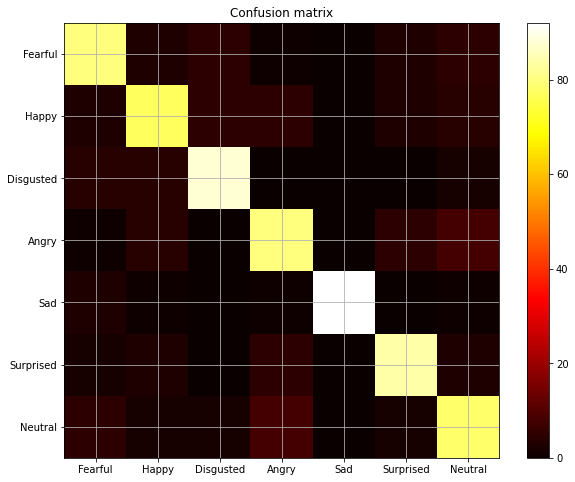

NameError: ignored

In [36]:
# plots
CM(model, X_test,y_test, labels_path)
trains_vs_val(history)

**Transfer learning**

In [ ]:
X_traincnn_TL_zeros= np.zeros(X_traincnn.shape)

X_traincnn_TL = np.concatenate([X_traincnn,X_traincnn_TL_zeros], axis=3)
X_traincnn_TL = np.concatenate([X_traincnn_TL,X_traincnn_TL_zeros], axis=3)

X_testcnn_TL_zeros= np.zeros(X_testcnn.shape)

X_testcnn_TL = np.concatenate([X_testcnn,X_testcnn_TL_zeros], axis=3)
X_testcnn_TL = np.concatenate([X_testcnn_TL,X_testcnn_TL_zeros], axis=3)



## Xception; vgg16.VGG16; Resnet50

base_model = tf.keras.applications.mobilenet(include_top=False,
                  input_shape = None,weights= 'imagenet'


                  )
base_model.trainable = False #<! Freeze the base model
base_model.summary()

##optimzers
initLr = 0.01
decay_s = 150
decay_r = 0.96
staircase = True
numEpochs = 450 
batchSize = 1000
lrSchedule = tf.keras.optimizers.schedules.ExponentialDecay(initLr, decay_steps = decay_s, decay_rate = decay_r, staircase = staircase)
# lrSchedule = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate= initLr, decay_steps=decay_s, alpha=0.0, name=None)



hOpt = Adam(learning_rate = lrSchedule, name = "Adam")
# hOpt = SGD(learning_rate = lrSchedule, name = "SGD")


inputlayer = Input(shape=(X_traincnn_TL.shape[1],X_traincnn_TL.shape[2], 3))
x = base_model(inputlayer, training = False) #<! Think of the Dropout / Batch Normalization
# x = base_model(inputlayer) #<! Think of the Dropout / Batch Normalization
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation= 'relu')(x)
outputs = Dense(7, activation='softmax')(x)
model = Model(inputs=inputlayer, outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer=hOpt, metrics=['accuracy'])

history = model.fit(X_traincnn_TL, y_train, batch_size=batchSize, epochs=numEpochs, verbose=1, validation_split=0.2)

score = model.evaluate(X_testcnn_TL, y_test, verbose=0)
print('\nScore: ', score)

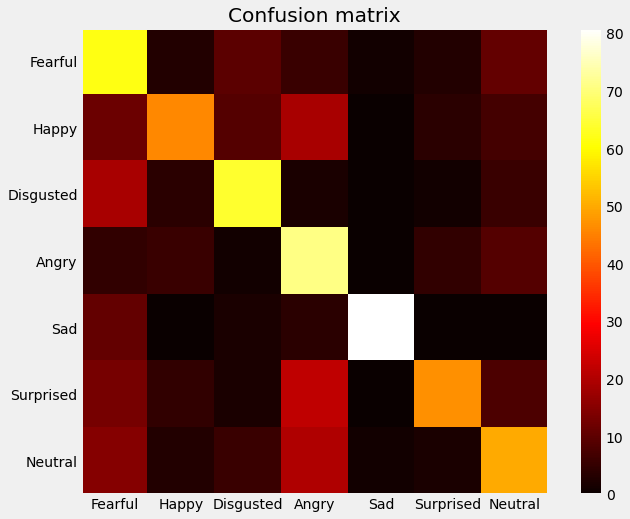

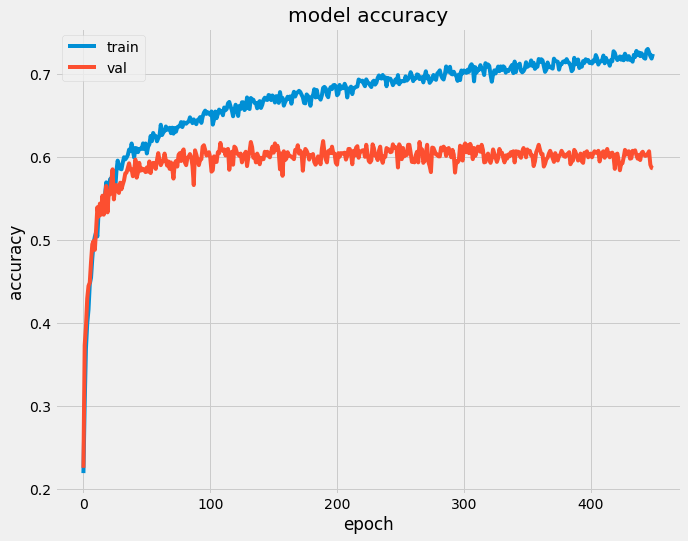

In [18]:
# plots
CM(model, X_testcnn_TL,y_test, labels_path)
trains_vs_val(history)

In [10]:
model.save('/content/gdrive/My Drive/Final_project_Naya/Mobile_net_ResNet50_model')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Final_project_Naya/Mobile_net_ResNet50_model/assets


In [ ]:
## Fine tuninng
base_model.trainable = True
base_model.summary()
initLr = 1e-5
decay_s = 150
decay_r = 0.96
staircase = True
numEpochs = 20 #<! Don't change
batchSize = 1000
lrSchedule = tf.keras.optimizers.schedules.ExponentialDecay(initLr, decay_steps = decay_s, decay_rate = decay_r, staircase = staircase)
hOpt = Adam(learning_rate = lrSchedule, name = "Adam")

model.compile(loss='categorical_crossentropy', optimizer=hOpt, metrics=['accuracy'])

model.fit(X_traincnn_TL, y_train, batch_size=batchSize, epochs=numEpochs, verbose=1, validation_split=0.2)

In [ ]:
# plots
CM(model, X_testcnn_TL,y_test, labels_path)
trains_vs_val(history)

In [41]:
model.save('/content/gdrive/My Drive/Final_project_Naya/Mobile_net_TL_model')

INFO:tensorflow:Assets written to: Mobile_net_TL/assets


**CNN**

In [ ]:
#optimzers
initLr = 0.001
decay_s = 150
decay_r = 0.96
staircase = True
numEpochs = 1000 
batchSize = 1000
lrSchedule = tf.keras.optimizers.schedules.ExponentialDecay(initLr, decay_steps = decay_s, decay_rate = decay_r, staircase = staircase)

hOpt = Adam(learning_rate = lrSchedule, name = "Adam")
# hOpt = SGD(learning_rate = lrSchedule, name = "SGD")



model = Sequential()
model.add(Conv2D(24, (5,5), activation="relu", input_shape=(X_traincnn.shape[1],X_traincnn.shape[2], X_traincnn.shape[3]), padding= 'same'))
model.add(MaxPooling2D(pool_size= (4,2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Conv2D(6, (5,5), activation="relu", padding= 'same'))
model.add(MaxPooling2D(pool_size= (4,2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# model.add(Conv2D(18, (5,5), activation="relu", padding= 'same'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(64, activation= 'relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation = 'softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=hOpt,
              metrics=['accuracy'])
history = model.fit(X_traincnn, y_train, batch_size=batchSize, epochs=numEpochs, verbose=1, validation_split=0.2)
score = model.evaluate(X_testcnn, y_test, verbose=0)
print('\nScore: ', score)



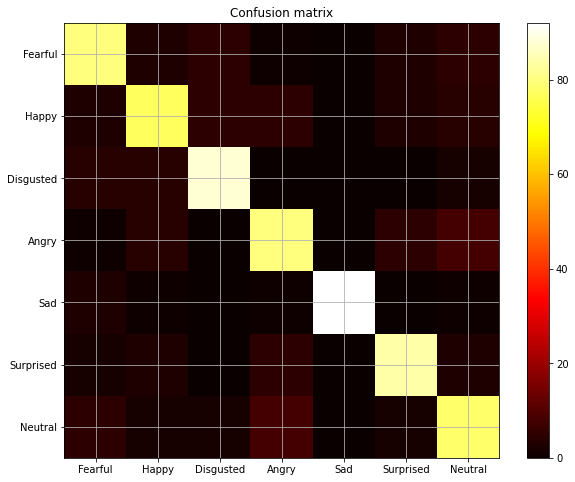

In [34]:
# plots
model = keras.models.load_model('/content/gdrive/My Drive/Final_project_Naya/CNN_model')
CM(model, X_testcnn,y_test, labels_path)
# trains_vs_val(history)

In [ ]:
# save model
model.save('/content/gdrive/My Drive/Final_project_Naya/CNN_model')

**LSTM**

In [ ]:
initLr = 0.001
decay_s = 150
decay_r = 0.96
staircase = True
numEpochs = 450 
batchSize = 1000
lrSchedule = tf.keras.optimizers.schedules.ExponentialDecay(initLr, decay_steps = decay_s, decay_rate = decay_r, staircase = staircase)

hOpt = Adam(learning_rate = lrSchedule, name = "Adam")
# hOpt = SGD(learning_rate = lrSchedule, name = "SGD")

input_shape=(X_traincnn.shape[1],X_traincnn.shape[2])
# build network topology
model = keras.Sequential()

# 2 LSTM layers
model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
model.add(keras.layers.LSTM(64))
model.add(BatchNormalization())
model.add(keras.layers.Dropout(0.3))


# dense layer
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(BatchNormalization())


# output layer
model.add(keras.layers.Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=hOpt,
              metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=batchSize, epochs=numEpochs, verbose=1, validation_split=0.2)
score = model.evaluate(X_test, y_test, verbose=0)
print('\nScore: ', score)


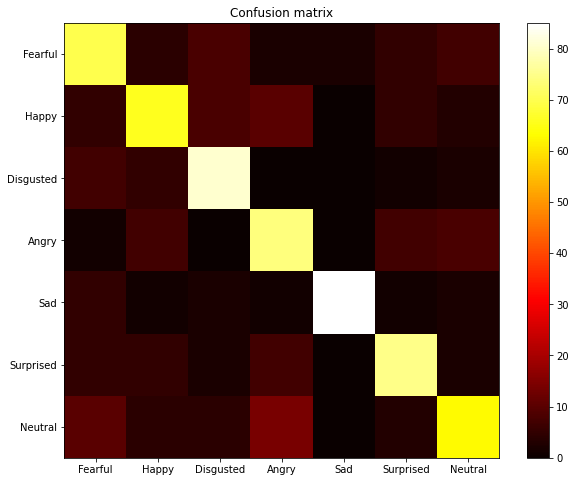

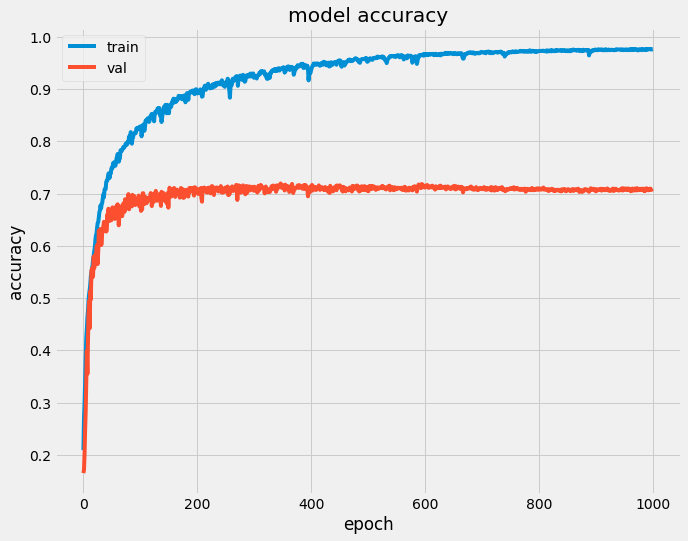

In [42]:
# Plots
CM(model, X_test,y_test, labels_path)
trains_vs_val(history)

In [41]:
# save model
model.save('/content/gdrive/My Drive/Final_project_Naya/LSTM_model')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Final_project_Naya/LSTM_model/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Final_project_Naya/LSTM_model/assets


## Autoencoder

In [23]:
def GenNnModels(numRows , numCols , numChannels ):
  encModel = Sequential()
  encModel.add(Conv2D(12, (5,5), activation="relu", input_shape=(numRows,numCols, numChannels), padding= 'same'))
  encModel.add(MaxPooling2D(pool_size= (2,2)))
  encModel.add(Conv2D(6, (5,5), activation="relu", padding= 'same'))




  decModel =  Sequential()
  decModel.add(Conv2D(6, (5, 5), activation = "relu", padding = "same",input_shape = (250,20,6)))
  decModel.add(UpSampling2D((2, 2)))
  decModel.add(Conv2D(12, (5, 5), activation = 'relu',padding = 'same'))
  decModel.add(Conv2D(1, (5, 5), activation = 'sigmoid', padding = 'same'))


  autoEncModel = Sequential([encModel, decModel])
  return encModel, decModel, autoEncModel

encModel, decModel, autoEncModel = GenNnModels( X_traincnn.shape[1], X_traincnn.shape[2], X_traincnn.shape[3])


autoEncModel.summary()




Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_20 (Sequential)   (None, 250, 20, 6)        2118      
_________________________________________________________________
sequential_21 (Sequential)   (None, 500, 40, 1)        3019      
Total params: 5,137
Trainable params: 5,137
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train Model
numEpochs   = 30
batchSize   = 750
shuffleFlag = True

initLr = 0.001
decay_s = 150
decay_r = 0.96
staircase = True

lrSchedule = tf.keras.optimizers.schedules.ExponentialDecay(initLr, decay_steps = decay_s, decay_rate = decay_r, staircase = staircase)


hOpt = Adam(learning_rate = lrSchedule, name = "Adam")

# The reasoning for Binary Cross Entropy Loss: The continuous Bernoulli: fixing a pervasive error in variational autoencoders
# Anoter point of view: Like Logistic Regressio, trying to get the value of probability
# autoEncModel.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ["mse"]) #<! More advanced
autoEncModel.compile(optimizer = hOpt, loss = 'mse', metrics = ["mse"]) #<! The classic loss for this task

autoEncModel.fit(X_traincnn, X_traincnn,
                epochs = numEpochs,
                batch_size = batchSize,
                shuffle = shuffleFlag,
                validation_data = (X_testcnn, X_testcnn))

audioEnc = encModel.predict(X_testcnn)
audioDec = decModel.predict(audioEnc)

In [ ]:
actual = X_train[0]
plt.figure(figsize= (10,8))
librosa.display.specshow(actual, sr= sr, hop_length= hop_length)
plt.xlabel('Time')
plt.ylabel('MFCC')
plt.title(f'Actual')
plt.colorbar()
plt.show()

decoded = np.squeeze(audioDec[1000])
plt.figure(figsize= (10,8))
librosa.display.specshow(decoded, sr= sr, hop_length= hop_length)
plt.xlabel('Time')
plt.ylabel('MFCC')
plt.title(f'Decoded')
plt.colorbar()
plt.show()

In [ ]:
decoded_audio = librosa.feature.inverse.mfcc_to_audio(audioDec)


## Live testing

In [ ]:
"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
audio_test, sr = get_audio()
audio_test = np.float32(audio_test)

sample_rate = 22050
n_fft = 2048 
hop_length = 512 
n_mfcc = 40
padding_val = 500

proccessed_live_audio = librosa.feature.mfcc(audio_test, n_fft= n_fft, hop_length= hop_length, n_mfcc= n_mfcc).T
extra = np.zeros([padding_val, n_mfcc])
extra[0:proccessed_live_audio.shape[0],:] = proccessed_live_audio
extra = np.expand_dims(extra, axis=0)
extra = np.expand_dims(extra, axis=3)

audio_pred = model.predict(extra)
labels_doc = pd.read_csv('/content/gdrive/My Drive/Final_project_Naya/labels_doc.csv')
audio_emotion = str(labels_doc.loc[labels_doc.label_num==audio_pred.argmax(),'label_name'].values[0])
print(f'\nYou are feeling {audio_emotion}!!!\n')


# Generator based networks

**Fix wav files metadata bug (resaving them)**

In [21]:

# from scipy.io.wavfile import write
# write('/content/gdrive/My Drive/Final_project_Naya/Test_generator/Angry/3.wav', sr, y)
SR = 22050
import soundfile as sf
audio_path = '/content/drive/My Drive/Final_project_Naya/Emotions/'
fixed_audio_path = '/content/drive/My Drive/Final_project_Naya/fixed_audio_files/'

for subdir, dirs, files in os.walk(audio_path):
  file_num = 0
  path_components = subdir.split("/")
  label = path_components[-1]
  print(label)
  # if label!= 'Sad':
  #   continue
  for file_wav in files:  
    # print(file_wav)
    # Load librosa array, obtain mfcss, add them to dict.
    signal, sample_rate = librosa.load(os.path.join(subdir,file_wav),sr = SR)
    sf.write(f'/content/drive/My Drive/Final_project_Naya/fixed_audio_files/{label}/{label}_{file_num}.wav', signal, sample_rate)
    file_num += 1





Fearful
Happy
Disgusted
Angry
Sad
Suprised
Neutral


**CNN**

In [5]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

def paths_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))


def path_to_audio(path):
    """Reads and decodes an audio file."""

    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio



def audio_to_fft(audio):
    # Since tf.signal.fft applies FFT on the innermost dimension,
    # we need to squeeze the dimensions and then expand them again
    # after FFT
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    # Return the absolute value of the first half of the FFT
    # which represents the positive frequencies
    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])


# Get the list of audio file paths along with their corresponding labels
DATASET_AUDIO_PATH = '/content/gdrive/My Drive/Final_project_Naya/fixed_audio_files/'

class_names = os.listdir(DATASET_AUDIO_PATH)
print("Our class names: {}".format(class_names,))

audio_paths = []
labels = []
for label, name in enumerate(class_names):
    print("Processing emotion {}".format(name,))
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(audio_paths), len(class_names))
)
SHUFFLE_SEED = 123
SAMPLING_RATE = 22050

# Shuffle
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(labels)

VALID_SPLIT = 0.2
# Split into training and validation
num_val_samples = int(VALID_SPLIT * len(audio_paths))
print("Using {} files for training.".format(len(audio_paths) - num_val_samples))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]

print("Using {} files for validation.".format(num_val_samples))
valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

BATCH_SIZE = 500
# Create 2 datasets, one for training and the other for validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)



# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 64, 2)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.BatchNormalization()(x)
    x = residual_block(x, 48, 3)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.BatchNormalization()(x)
    x = residual_block(x, 32, 3)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(64, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model = build_model((SAMPLING_RATE // 2, 1), len(class_names))


model.summary()

#optimzers
initLr = 0.001
decay_s = 150
decay_r = 0.96
staircase = True
numEpochs = 200 
lrSchedule = tf.keras.optimizers.schedules.ExponentialDecay(initLr, decay_steps = decay_s, decay_rate = decay_r, staircase = staircase)
hOpt = tf.keras.optimizers.Adam(learning_rate = lrSchedule, name = "Adam")
# Compile the model using Adam's default learning rate
model.compile(
    optimizer=hOpt, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

history = model.fit(
    train_ds,
    epochs=numEpochs, validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb])


Our class names: ['Angry', 'Disgusted', 'Happy', 'Neutral', 'Suprised', 'Fearful', 'Sad']
Processing emotion Angry
Processing emotion Disgusted
Processing emotion Happy
Processing emotion Neutral
Processing emotion Suprised
Processing emotion Fearful
Processing emotion Sad
Found 12798 files belonging to 7 classes.
Using 10239 files for training.
Using 2559 files for validation.
Epoch 1/200
21/21 [==============================] - 976s 32s/step - loss: 1.6963 - accuracy: 0.3344 - val_loss: 1.8439 - val_accuracy: 0.2943
Epoch 2/200
21/21 [==============================] - 121s 5s/step - loss: 1.3846 - accuracy: 0.4488 - val_loss: 1.6140 - val_accuracy: 0.3654
Epoch 3/200
21/21 [==============================] - 121s 5s/step - loss: 1.2605 - accuracy: 0.4929 - val_loss: 1.5126 - val_accuracy: 0.3931
Epoch 4/200
21/21 [==============================] - 121s 5s/step - loss: 1.2211 - accuracy: 0.5017 - val_loss: 1.4189 - val_accuracy: 0.4635
Epoch 5/200
21/21 [==============================]

KeyboardInterrupt: ignored

In [ ]:
model.save('/content/gdrive/My Drive/Final_project_Naya/Generator_CNN_model')

**Transfer learning (yamnet)**

In [ ]:
!pip install tensorflow_io
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav



pd_data = pd.read_csv('/content/gdrive/My Drive/Final_project_Naya/audio_files_df.csv')
my_classes = ['Happy', 'Fearful', 'Disgusted', 'Sad', 'Neutral', 'Suprised', 'Angry']

map_class_to_id = {'Happy':0, 'Fearful':1, 'Disgusted':2,'Sad':3, 'Neutral':4,'Suprised':5,'Angry':6}

# filtered_pd = pd_data[pd_data.category.isin(my_classes)]

# class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
# filtered_pd = filtered_pd.assign(target=class_id)

# full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
# filtered_pd = filtered_pd.assign(filename=full_path)
filtered_pd = pd_data

filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec





def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec


cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(500).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(500).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(500).prefetch(tf.data.AUTOTUNE)


my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(7)
], name='my_model')

my_model.summary()


initLr = 0.00005
decay_s = 150
decay_r = 0.96
staircase = True
numEpochs = 700 
batchSize = 700
lrSchedule = tf.keras.optimizers.schedules.ExponentialDecay(initLr, decay_steps = decay_s, decay_rate = decay_r, staircase = staircase)
hOpt = tf.keras.optimizers.Adam(learning_rate = lrSchedule, name = "Adam")
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer=hOpt,
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

history = my_model.fit(train_ds,
                       epochs=numEpochs,
                       validation_data=val_ds
                       )

#callbacks=callback

loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)


In [ ]:
testing_wav_file_name = '/content/gdrive/My Drive/Final_project_Naya/fixed_audio_files/Sad/Sad_1000.wav'
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)


scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')